In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [68]:
class Kmeans:
    def __init__(self, filepath, k):
        self.dataset = pd.read_csv(filepath)
        self.k = k
        self.X = self.dataset[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']].values
        self.apply_pca()
        self.X = (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)
        

    def apply_pca(self):
        covariance_matrix = np.cov(self.X, rowvar=False)
        self.eigenvalues, self.eigenvectors = np.linalg.eig(covariance_matrix)
        sorted_indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[:, sorted_indices]
        total_variance = np.sum(self.eigenvalues)
        variance_ratio = self.eigenvalues / total_variance
        cumulative_variance = np.cumsum(variance_ratio)
        self.n_components = np.argmax(cumulative_variance >= 0.95) + 1
        self.eigenvectors = self.eigenvectors[:, :self.n_components]
        self.X = np.dot(self.X, self.eigenvectors)
    

    

    

    def calculate_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def kmeans(self, max_iters=100):
        initial_indices = np.random.choice(self.X.shape[0], self.k, replace=False)
        centroids = self.X[initial_indices]
        
        for iteration in range(max_iters):
            clusters = [[] for _ in range(self.k)]  

            for point in self.X:
                distances = [self.calculate_distance(point, centroid) for centroid in centroids]
                nearest_centroid_index = np.argmin(distances)
                clusters[nearest_centroid_index].append(point)

            new_centroids = []
            for i, cluster in enumerate(clusters):
                if len(cluster) > 0:
                    cluster_points = np.array(cluster)
                    ncentroid = np.mean(cluster_points, axis=0)
                else:
                    ncentroid = centroids[i]  
                new_centroids.append(ncentroid)

            new_centroids = np.array(new_centroids)

            centroids = new_centroids

        inertia = 0
        for cluster_index, cluster in enumerate(clusters):
            for point in cluster:
                inertia += self.calculate_distance(point, centroids[cluster_index]) ** 2
        
        return centroids, clusters, inertia
        
    def silhouette_score(self, clusters):
        silhouette_scores = []

        for cluster_index, cluster in enumerate(clusters):
            for point in cluster:
                intra_distances = [
                    self.calculate_distance(point, other_point)
                    for other_point in cluster if not np.array_equal(point, other_point)
                ]
                a_i = np.mean(intra_distances) if intra_distances else 0
                
                nearest_distances = []
                for other_cluster_index, other_cluster in enumerate(clusters):
                    if other_cluster_index != cluster_index:
                        inter_distances = [
                            self.calculate_distance(point, other_point) for other_point in other_cluster
                        ]
                        nearest_distances.append(np.mean(inter_distances) if inter_distances else float('inf'))
                
                b_i = min(nearest_distances) if nearest_distances else 0

                s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0
                silhouette_scores.append(s_i)
        
        return np.mean(silhouette_scores)

    def plot_clusters(self, X, centroids, clusters):
        plt.figure(figsize=(8, 6))
        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        for cluster_index, cluster in enumerate(clusters):
            cluster_points = np.array(cluster)
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                        color=colors[cluster_index % len(colors)], 
                        label=f'Cluster {cluster_index + 1}')
        
        # Plot centroids
        centroids = np.array(centroids)
        plt.scatter(centroids[:, 0], centroids[:, 1], 
                    color='black', 
                    marker='x', 
                    s=100, 
                    label='Centroids')
        
        plt.title('K-Means Clustering')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.legend()
        plt.grid(True)
        plt.show()


Silhouette Score: 0.7000264713345788


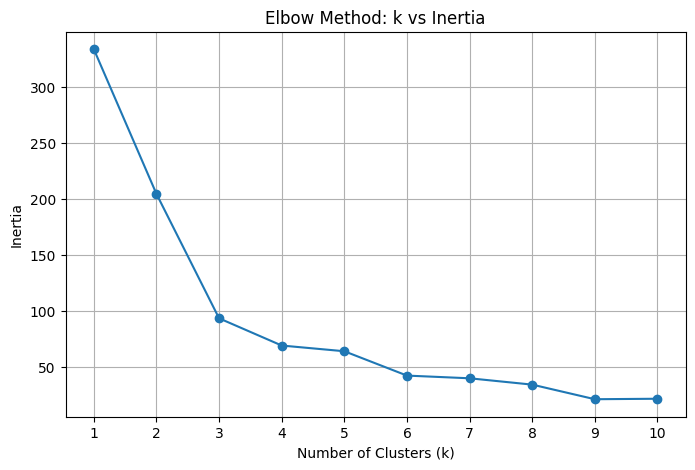

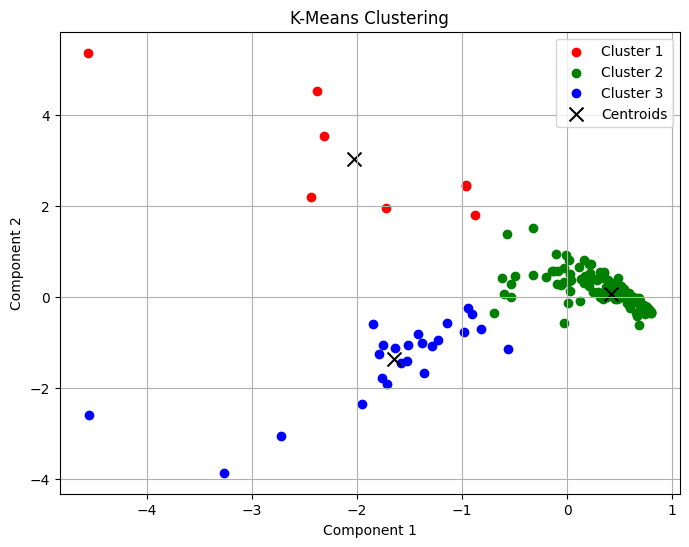

In [69]:
if __name__ == "__main__":
    filepath = r"C:\Users\pkmna\Downloads\data.csv"
    k = 3
    kmeans = Kmeans(filepath, k)
    centroids, clusters, inertia = kmeans.kmeans()
    score = kmeans.silhouette_score(clusters)
    print("Silhouette Score:", score)
    
    
    k_values = range(1, 11)
    inertia_values = []

    for k in k_values:
        kmeans = Kmeans(filepath, k)
        _, _, inertia = kmeans.kmeans()
        inertia_values.append(inertia)

    
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia_values, marker='o')
    plt.title('Elbow Method: k vs Inertia')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()
    kmeans.plot_clusters(kmeans.X, centroids, clusters)